## reaction diffusion simulations

In [151]:
import numpy as np
import pandas as pd
import uuid

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

from copy import deepcopy

### define particles and trajectory classes
only property of particle-types is diffusion and a geometry object

**to clean up**
particle types contain their uni-molecular reactions but this should be separated to mirror the case of bi-molecular reactions. i.e define inducts (uni and bi-), each induc class has a method to get their instances in the simulation.
traj has uni- and b- reactors, that call the method, loop over the reactions associated with the inducts, and effects them

In [167]:
class energyterm(object):
    pass

class bondterm(energyterm):
    def __init__(self, k, d, part1=None):
        self.elastic=k
        self.distance=d
        self.partner = part1
        self.name=uuid.uuid4()
        
    def assign_partner(self,part1):
        self.partner = part1
    
    def force(self, position):
        partner = self.partner
        pos1 = partner.pos
        ## we use geometry from partner, ... what happend if they are different?
        if(partner.ptype.geometry.bc == 'pbc'):
            box = partner.ptype.geometry.size
            pos1 = pos1 - np.floor(pos1/box) * box
            delta = (pos1 - position)
            delta = delta - np.rint(delta/box)* box
        else:
            delta = (pos1 - position)
        dist = np.sqrt((delta*delta).sum())


        factor = self.elastic*(dist-self.distance)
        force = factor*delta/dist
        return force 
        


In [176]:
class hardcore(energyterm):
    def __init__(self, k, d, part1):
        self.elastic=k
        self.distance=d
        self.partner = part1
        self.name=uuid.uuid4()

    def force(self, position):
        partner = self.partner

        pos1 = partner.pos
        ## we use geometry from partner, ... what happend if they are different?
        if(partner.ptype.geometry.bc == 'pbc'):
            box = partner.ptype.geometry.size
            pos1 = pos1 - np.floor(pos1/box) * box
            delta = (pos1 - position)
            delta = delta - np.rint(delta/box)* box
        else:
            delta = (pos1 - position)
        dist = np.sqrt((delta*delta).sum())

        if dist<self.distance:
            factor = self.elastic*(dist-self.distance)
            force = factor*delta/dist
        else:
            force = np.array([0.,0.])
            
        return force 

In [ ]:
#p1 = ptype(1e-2,'p1', geometry(2,20.))
#part1 = particle(ptype=p1,age=0,pos=np.array([0.,0.]),energyterms=[])
#part2 = particle(ptype=p1,age=0,pos=np.array([1.,0.]),energyterms=[])
#bond1 = bondterm(1,1.5,part2)
#bond2 = bondterm(1,1.5,part1)


#part1.add_energyterm(bond1)
#part2.add_energyterm(bond2)

#part2b = part2.step(10)
#part2b.pos

In [3]:
class ptype:
    """basic particle type, with name and physical properties
    it also has a list of unimolecular reactions A -> products
    """
    def __init__(self,diffusion,name,geometry):
        self.diffusion=diffusion
        self.name=name
        self.unimolecular_reactions = []
        self.unimolecular_probs = []
        self.geometry= geometry
        
    def add_reaction(self,reaction):
        """adds a unimolecular_reaction to the list for this particle type
        and updates the probabilities function"""
        (self.unimolecular_reactions).append(reaction)
        rates = np.array([rea.rate for rea in self.unimolecular_reactions])
        self.unimolecular_probs = rates
        
    def choose_reaction(self,dt):
        """chooses one reaction (or none) for a given time step
        that reaction can then be effected on a particle with effect_reaction
        """
        if len(self.unimolecular_probs)==0:
            return None
        else:
            rates = self.unimolecular_probs
            probs = (rates/rates.sum())*(1 - np.exp( - dt* rates.sum()))
            #print("Cumulative probs: ",np.cumsum(probs))
            alpha=np.random.uniform(size=1)
            conf = np.cumsum(probs)>alpha
            if any(conf):
                ii = np.argmax(conf)
                #print("Chosen rection %s" % self.unimolecular_reactions[ii].name)
                return self.unimolecular_reactions[ii]
            else:
                return None
        

class geometry(object):
    """a basic basic geometry specification
    ideally it would include boundary conditions, dimensionality
    external potentials, etc. 
    It's used to evolve the dynamics of particles, 
    so each particle type is attached to a geometry object at construction
    """
    def __init__(self, size, dim=2):
        self.dim=dim
        self.size=size
        self.bc='pbc'
        

class particle:
    """particle instance, it has an id, position, age, types, etc."""
    def __init__(self, ptype, pos, age=0, id=None, energyterms=None):
        if id==None:
            self.id = uuid.uuid4()
        else:
            self.id = id
        self.ptype = ptype
        self.age = age
        if energyterms==None:
            self.energyterms = []
        else:
            print("creating particle with %d energy terms" % len(energyterms))
            self.energyterms=energyterms
        self.pos = pos
        
    def add_energyterm(self, energyterm):
        (self.energyterms).append(energyterm)
            
    def step(self,dt,kT=None):
        if len(self.energyterms)>0 and not kT==None:
            #print("force!")
            forces = [ eterm.force(self.pos) for eterm in self.energyterms]
            force = np.vstack(forces).sum(axis=0)
            dx = force*self.ptype.diffusion*dt/kT
        else:
            dx = 0
        pos1 = self.pos + dx + np.sqrt(2*self.ptype.diffusion*dt)*np.random.normal(0, 1, 2)
        
                                        
        if(self.ptype.geometry.bc == 'pbc'):
            box = self.ptype.geometry.size
            pos1=pos1 - np.floor(pos1/box) * box
        #print("type %s, age %d"% (self.ptype.name, self.age))
        #print("pos",pos1)
        self.pos = pos1
        self.age += 1
        #pnew = particle(self.ptype, pos1,
        #                age = self.age + 1, id = self.id)
        return self

    def deghost(self, swap=None):
        """ removes energyterms referring to this particle """
        for eterm in self.energyterms:
            part = eterm.partner
            for partner_eterm in part.energyterms:
                if (partner_eterm.partner)==self:
                    print("deghosted %s" % part.id)
                    if swap==None:
                        (part.energyterms).remove(partner_eterm)
                    else:
                        partner_eterm.partner=swap
    
    
        
class traj:
    """a traj is a list (frames) of lists of particles"""
    
    def __init__(self, particles=[]):
        self.ptraj = []
        self.nframes = 0
        (self.ptraj).append(particles)

    def __getitem__(self, key):
        if isinstance(key, slice):
            print("sliced trajectory")
        outt = traj()
        outt.ptraj=self.ptraj[key]
        outt.nframes = len(outt.ptraj)
        return outt
        
    def describe(self):
        n = len(self.ptraj)
        print("Length %d (%d)" % (n,self.nframes))
        
    def step(self,dt,kT=None):
        """updates the latest frame"""
        newvals=[]
        for pa in (self.ptraj)[self.nframes]:
            pa1 = pa.step(dt,kT)
            newvals.append(pa1)
        (self.ptraj)[self.nframes] = newvals
        #(self.ptraj).append(newvals)
        #self.nframes = (self.nframes)+1
        
    def store(self):
        """hard-duplicates the latest frame"""
        newvals = []
        for pa in (self.ptraj)[self.nframes]:
            pa1 = particle(ptype=pa.ptype, pos=pa.pos,age=pa.age,id=pa.id)
            newvals.append(pa1)
            
        (self.ptraj).append((self.ptraj)[self.nframes])
        (self.ptraj)[self.nframes]=newvals
        self.nframes = (self.nframes)+1
                

    def react_unimolecular(self, dt):
        ###### unimolecular reactions would be defined 
        ###### on unm_inducts to mimick other orders
        ###### then here we can pass the set of unim_inducts 
        """loops over particles and reacts them with their unimolecular reactions
         unimolecular reactions are associated to the incoming pair
        """
        newvals=[]
        for pa in (self.ptraj)[self.nframes]:
            react = pa.ptype.choose_reaction(dt)
            if(not react==None):
                pa1 = react.effect_reaction(pa)
                if not pa1==None:
                    for pa11 in pa1:
                        newvals.append(pa11)
            else:
                newvals.append(pa)
        
        (self.ptraj)[self.nframes] = newvals
        
    def react_bimolecular(self, dt, bim_inducts, verbose=False):
        """ bimolecular reactions        
        """
        frame = (self.ptraj)[self.nframes]
        if verbose:
            print("reacting frame %d" % self.nframes)
        #loop over inducts, get instances, choose reaction, effect reaction
        # remember to add the particles that are not in any instance
        for induct in bim_inducts:
            #print("induct name: %s"%induct.name)
            induct_instances = induct.get_ec(frame)
            ##if len(induct_instances)>0:
            ##    print(induct_instances)
            for EC_instance in induct_instances:
                react = induct.choose_reaction(dt)
                if(not react==None):
                    pa1 = react.effect_reaction(EC_instance)
                    ## remove incoming particles from frame
                    for part in EC_instance:
                        #### EC_instance is a list of two (index,particle)
                        #print("removing part %d" % part.id)
                        frame.remove(part)
                    ## add educts
                    if not pa1==None:
                        for pa11 in pa1:
                            frame.append(pa11)
                            
            

5

In [43]:
#col_dict = {'type 1':'red','type 1b':'blue','type 2':'orange'}
#col_dict = {'type 1':1,'type 1b':2,'type 2':3}
#size_dict = {'type 1':10,'type 1b':20,'type 2':30}

### http://stackoverflow.com/questions/9401658/how-to-animate-a-scatter-plot

def plt_traj2(traj, col_dict, size_dict):
    """plots a trajectory"""
    ptraj = (traj.ptraj)
    
    # the first particle determines the size (should be the max here)
    size = (ptraj[0][0]).ptype.geometry.size
    
    fig = plt.figure(figsize=(8,8))
    ax = plt.axes(xlim=(0, size), ylim=(0, size))
    scat = ax.scatter([],[], c=[], marker='o', lw=2, vmin = 0, vmax=20)
        
    def init():
        scat.set_offsets(np.hstack(([], [])))
        return scat,
        
    def animate(i):
        x = [p.pos[0] for p in ptraj[i]]
        y = [p.pos[1] for p in ptraj[i]]
        cols = [1.*col_dict[p.ptype.name] for p in ptraj[i]]
        sizs = [size_dict[p.ptype.name] for p in ptraj[i]]
        scat.set_offsets(np.vstack((x, y)).T)
        scat._sizes = np.array(sizs)*35
        scat.set_array(np.array(cols))
        return scat,

    anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=traj.nframes, interval=20, blit=True)
    return anim


### reshape trajectory for analysis/postprocessing
def reshape(traj):
    """converts a frame-based trajectory into a id-based data-frame
    for lifetimes and concentrations
    
    """
    pp=[]
    for i,frame in enumerate(traj.ptraj):
        for part in frame:
            pp.append([part.id,part.age,part.pos[0],part.pos[1],i,part.ptype.name])
    gg = pd.DataFrame(pp,columns=['ID','age','x','y','frame','type_name'])
    return gg
 

## define reactions classes

reaction class is the used for uni- and bi- molecular reactions
each has a method to effect it (i.e. apply it to the inducts and yield the products)
and one single rate


In [4]:
class reaction:
    """base class for reactions, just a name, a rate and a counter"""
    def __init__(self,name,rate):
        self.rate = rate
        self.name = name
        self.counter = 0
        #print(self)
        
    def report(self):
        reaction_type = type(self).__name__
        print("   %s %s: counter %d" % (reaction_type, self.name, self.counter))
        print("        rate: %d"% self.rate)
        
    def reset(self):
        self.counter = 0
        


### uni-molecular reactions
ptypes are the inducts (this should be changed)
the can be
* decay A->0
* convert A->B 
* fission A-> B+C (e.g. unbinding, or dimerization breaking)

once could add multiple fission types A->B+C+D, etc.

In [5]:
### ============== UNI_MOLECULAR REACTIONS ===============================
        
class decay_reaction(reaction):
    """ unimolecular decay with given rate
        A -> 0
    """
    def __init__(self, name, rate):
        super(decay_reaction,self).__init__(name,rate)
        
    def effect_reaction(self,particle_in):
        self.counter += 1
        
        ## since we destroy a particle, we need to deghost
        particle_in.deghost()
        return None
    
class convert_reaction(reaction):
    """ unimolecular conversion with given rate to given type 
        A -> B
        
        the new particle is actually the old one, with new age and type
        to allow keeping the energy terms in case this is needed.
        default is to keep_energy, use keepenergy=None not to
    """
    def __init__(self,  name, rate, outtype,  keepenergy = 0):
        self.outtype=outtype
        self.keepenergy = keepenergy
        super(convert_reaction,self).__init__( name, rate )
        
    def effect_reaction(self,particle_in):
        self.counter += 1
        if self.keepenergy==None:
            particle_in.energyterms=[]
        ## otherwise energyterms are kept
        particle_in.ptype= self.outtype
        particle_in.age= 0 
        particle_in.id = uuid.uuid4()
        ## return a singleton list for consistence with other reactions
        return [particle_in]
        #return [particle(self.outtype, particle_in.pos )]

class fission_reaction(reaction):
    """ unimolecular fission with given rate to given type 
        A -> B+C
        default is to loose all energyterms
        use keepenergy=0 to keep them to the first educt, 
        keepenergy=1 to pass it to the second
    """
    def __init__(self,  name, rate, outtype1, outtype2, keepenergy=None):
        self.outtype1=outtype1
        self.outtype2=outtype2
        self.keepenergy = keepenergy
        super(fission_reaction,self).__init__( name, rate)
        
    def effect_reaction(self,particle_in):
        keepenergy = self.keepenergy
        self.counter += 1
        pos = particle_in.pos
        types=[self.outtype1,self.outtype2]
        if not keepenergy==None and keepenergy<2:
            particle_in.ptype= types[keepenergy]
            particle_in.age= 0 
            particle_in.id = uuid.uuid4()
            particle_out1 = particle_in
            particle_out2 = particle(types[1-keepenergy], pos )
        else:
            particle_out1 = particle(types[0], pos )
            particle_out2 = particle(types[1], pos )
        return [particle_out1 , particle_out2  ]  

In [6]:
membrane=geometry(dim=2,size=20)
p1 = ptype(1,"A1",membrane)
p2 = ptype(1,"B1",membrane)

#conv = convert_reaction(name="con1",outtype=p2,rate=10,keepenergy=0)
#fiss = fission_reaction(name='fission',outtype1=p1,outtype2=p2,rate=2,keepenergy=0)
#p1.add_reaction(conv)

part1 = particle(p1,np.array([0,0]))
part2 = particle(p1,np.array([0,0]))

part1.add_energyterm(bondterm(1,1,part2))
part2.add_energyterm(bondterm(1,1,part1))

print(part1.id)

print(part2.id)

99c96c7f-cab5-4f2d-96d5-67e6fd818426
998dabce-a43e-40dc-89d8-615efb9f964b


In [ ]:
part1.deghost()

In [7]:
part2.energyterms

In [ ]:
#part1.add_energyterm(bond1)
#print(part1.id)
#part1.energyterms

In [ ]:
#part1 = particle(p1,np.array([0,0]))
#print(part1.id)
#part1.energyterms

In [ ]:
#pout = conv.effect_reaction(part1)
#print(pout[0].id)
#pout[0].energyterms

In [ ]:
#pout = fiss.effect_reaction(part1)
#pout[1].energyterms

### bi-molecular reactions
encounter-complexes are the inducts of bi-molecular reactions
they contain their reactions as ptypes contain the uni-molecular reactions
they can be:
* annihilation A+B -> 0
* fusion A+B -> C

In [8]:
#### abstract types of EC
### zz=bim_encunter_complex("bim1",p1,p3,.9)
#### add reactions to the EC_type
### r1 = annihilation_reaction("anni1", 1.1)
### r2 = ...
### zz.add_reaction(r1)
### zz.add_reaction(r2)

#### don't confuse with realizations of ECs in the simulation that can be obtained with
### zz.get_ec(t.ptraj[100])

### for a timestep, cycle over ectypes, get all ECs, 
### choose reaction for each ec, apply reaction

class encunter_complex_type:
    def __init__(self, name):
        self.name=name
        
class bim_encunter_complex(encunter_complex_type):
    
    def __init__(self, name, typ1,typ2, dist):
        self.type1 = typ1
        self.type2 = typ2
        self.dist= dist
        self.bim_reactions = []
        self.bim_probs = []
        super(bim_encunter_complex,self).__init__(name)
        
    def describe(self):
        print("Name: %s" % self.name)
        print("   Reactions:")
        for reac in self.bim_reactions:
            reac.report()
        
    def add_reaction(self,reaction):
        """adds a unimolecular_reaction to the list for this particle type
        and updates the probabilities function"""
        
        ## should check if reaction type is ok ...
        (self.bim_reactions).append(reaction)
        rates = np.array([rea.rate for rea in self.bim_reactions])
        self.bim_probs = rates

    def choose_reaction(self,dt):
        """chooses one reaction (or none) for a given time step
        that reaction can then be effected on a particle with effect_reaction
        """
        if len(self.bim_reactions)==0:
            return None
        else:
            rates = self.bim_probs
            probs = (rates/rates.sum())*(1 - np.exp( - dt* rates.sum()))
            #print("Cumulative probs: ",np.cumsum(probs))
            alpha=np.random.uniform(size=1)
            conf = np.cumsum(probs)>alpha
            if any(conf):
                ii = np.argmax(conf)
                #print("Chosen rection %s" % self.bim_reactions[ii].name)
                return self.bim_reactions[ii]
            else:
                return None
            
    def get_ec(self,particles_):
        """returns a list of instances of hte ECtype
        each of these are a vector of (two) (index, particle)
        bimolecular reactions effect_reaction functions take one of the instances
        and modify it
        
        the bimol react function of the traj loops over the instances,
        picks a reaction and reacts it
        """
        p1 = [i for i,p in enumerate(particles_) if p.ptype==self.type1]
        p2 = [i for i,p in enumerate(particles_) if p.ptype==self.type2]
        ec=[]
        #report_pairs=[]
        #print(p1)
        #print(p2)
        used_ones=[]
        for q1 in p1:
            for q2 in p2:
                if not q1 == q2 and not ((q1 in used_ones) or (q2 in used_ones)):
                    vec1= particles_[q1].pos - particles_[q2].pos
                    #print(vec1)
                    dist1= np.sqrt((vec1 * vec1).sum())
                    if dist1 < self.dist:
                        #report_pairs.append([q1,q2])
                        ec.append([particles_[q1],particles_[q2]])
                        ## we want particles to be in only one instance
                        ## otherwise we can react safely
                        used_ones.append(q1)
                        used_ones.append(q2)
        
        #print(report_pairs)
        return ec

In [117]:
class annihilation_reaction(reaction):
    """ annihilation reaction
        A + B -> 0
    """
    def __init__(self, name, rate):
        super(annihilation_reaction,self).__init__(name,rate)
        
    def effect_reaction(self,encunter_complex_in):
        
        for part in encunter_complex_in:
            part.deghost()
        self.counter += 1
        return None

class fusion_reaction(reaction):
    """ fusion reaction
        A + B -> C
        default is to keep all energy (e.g. keep bonds to both inducts)
    """
    def __init__(self, name, rate, outtype,keepenergy=[0,1]):
        self.outtype = outtype
        self.keepenergy=keepenergy
        super(fusion_reaction,self).__init__(name,rate)
        
    def effect_reaction(self,encunter_complex_in):
        self.counter += 1
        pos = None ## get particle pos in encounter complex in and average
        poss = [part.pos for part in encunter_complex_in]
        #print([part[0] for part in encunter_complex_in])    
        if not self.keepenergy == None:
            ## if only one, copy it and deghost the other
            ## if both, copy one, deghost the other assigning to the kept particle
            raise
        return [particle(self.outtype, poss[0])]
    



In [9]:
class ensemble(object):
    def __init__(self, trajs=[]):
        if not isinstance(trajs, list):
            trajs=[trajs]
        self.trajs=trajs
        self.params=[]
    
    def describe(self):
        print("Ensemble has %d trajectories" % len(self.trajs))
        for t in self.trajs:
            t.describe()
    
    def add_traj(self,traj):
        (self.trajs).append(traj)
        
    def lifetimes(self,doplot=True):
        """plots the lifetime distributions of the different species in the ensemble
        returns a grouped set by species with the individual lifetimes
        """
        res_list=[]
        trj_index = np.array(range(len(self.trajs))).astype('str')
        for t in self.trajs:
            ## get lifetime for all particles, flatten and drop ID
            tr = reshape(t).groupby(by=['ID','type_name']).agg({'age':'max'})
            tr2 = tr.rename(index=str).reset_index().drop('ID',axis=1)
            res_list.append(tr2)
        lifes = pd.concat(res_list,ignore_index=True)
        if doplot:
            plt.figure()
            axes = lifes.hist(by='type_name', bins=30)
            #for ax in np.ravel(axes):
            #    ax.set_xlabel("lifetime (frames)")
            #    ax.set_ylabel("freq")
            plt.tight_layout()
            plt.show()
        lifes2 = lifes.groupby('type_name')
        return lifes2
    
    def concentrations(self,species,init_val=0,doplot=True):
        ### get concentrations as a function of frame
        ### group by frame and type, then count particles of each type
        res_list=[]
        for i,t in enumerate(self.trajs):
            ## get lifetime for all particles, flatten and drop ID
            tr = reshape(t).groupby(by=['frame','type_name']).agg({'ID':'count'})
            tr['trj_in']=str(i)
            tr2 =tr.rename(index=str).reset_index()
            res_list.append(tr2)
        counts = pd.concat(res_list,ignore_index=True)
        
        
        ## group_by species and select the one we want
        rr=counts.groupby('type_name').get_group(species)
        ## clean up the pandas mess and sort
        rr=rr.fillna(0).drop('type_name',1)
        rr3=rr.groupby('frame').agg({'ID':{'mea':'mean', 'sd':'std'}}).rename(index=str).reset_index()
        rr4=rr3.set_index(rr3.frame)
        rr4.index = rr4.index.astype('int')
        rr5=rr4.sort_index()

        ## fit with specified initial value
        import scipy
        vals1=scipy.optimize.curve_fit(
        lambda t,a,b: a*(1-np.exp(-t/b)),
            np.array(rr5.ID.mea.index),  np.array(rr5.ID.mea)-init_val )

        if doplot:
            fun = lambda t: vals1[0][0]*(1-np.exp(-t/vals1[0][1]))

            plt.plot(np.array(rr5.ID.mea.index),  np.array(rr5.ID.mea), label=species)
            plt.plot(np.array(rr5.ID.mea.index), fun(np.array(rr5.ID.mea.index)))
            plt.legend()
            plt.show()
            
        return vals1,rr5

        
#    def save(self,filename):        
#    def load(self,filename):
        

## define a class to run the simulation
wraps in progress bar class, calls the integrator for diffusive motion, then reacts uni-molecular and bi-molecular (tri-molecular, etc.) reactions

In [241]:
from pyemma._base.progress import ProgressReporter

class runner(ProgressReporter):
    def __init__(self, nframes, timestep, stride=1):
        self.nframes = nframes
        self.timestep = timestep
        self.stride= stride
        self._progress_register(nframes,"Running simulation")
    
    def run(self, t2, reactions_mono= None, reactions_bim=None,verbose=True ,kT=None):
        if verbose:
            t2.describe()
        for i in range(self.nframes):
            if (i % self.stride)==0:
                #print("storing: %d" % i)
                t2.store()
            t2.step(self.timestep,kT)
            t2.react_unimolecular(self.timestep)
            if reactions_bim!=None:
                t2.react_bimolecular(self.timestep, reactions_bim)   
            self._progress_update(1)
        if verbose:
            t2.describe()
        ### report bimolecular complexes reactions
        if verbose:
            if reactions_bim!=None:
                for zz in reactions_bim:
                    zz.describe()

In [242]:
def random_init(n, types_list, fractions=[], cellsize=20):
    """aux function to create a randomized initial state 
    with a concentrations or the """
    if not isinstance(types_list,list):
        types_list=[types_list]
    if len(fractions)==0:
        fractions=np.ones(len(types_list))
        fractions = fractions/fractions.sum()
    counts = (n*fractions).astype('int')
    init_pos=[]
    for i, parttype in enumerate(types_list):
        for j in range(counts[i]):
            p = particle(parttype, 
                         pos=np.random.uniform(high=cellsize,low=0,size=2),age=0)
            init_pos.append(p)
            
    return traj(init_pos)

    

# SIMULATION 

##### initialize the system
define which particles we have, and how they react.

# analysis and post processing

In [ ]:
### do a movie of the trajectory (can be slowish to generate)

In [ ]:
col_dict = {'mono':0,'dimer':7, 'mono_mem':6, 'dimer2':15, 'mono_mem2':14, 'dimer4':20}
size_dict = {'mono':2,'dimer':5,'mono_mem':2, 'dimer2':5, 'mono_mem2':2, 'dimer4':5}
aa = plt_traj2(sett[1],col_dict, size_dict)
HTML(aa.to_html5_video())


In [ ]:
aa.save('im.mp4')

### liftimes

In [ ]:
## analyse life-time distribution and concentration of all species as a functin of time
## remember final semi column to prevent double plot
zz=em1.lifetimes(doplot=True);

In [ ]:
t=zz.get_group('dimer2')
uu=t.drop('type_name',1).dropna()
hist, bin_edges = np.histogram(uu.age,bins=50)
plt.plot(hist,marker='o')
plt.show()

### concentration and dimeric fractions

In [ ]:
ff = (em1.concentrations())
gg=ff.groupby('type_name')
rr=gg.get_group('dimer4')
rr=rr.fillna(0).drop('type_name',1)
#rr2 = rr.pivot(index='frame', columns='trj_in', values='ID')
rr3=rr.groupby('frame').agg({'ID':{'mea':'mean', 'sd':'std'}}).rename(index=str).reset_index()
#rr3.index = rr3.index.astype('int')
#rr3.head()
rr4=rr3.set_index(rr3.frame)
rr4.index = rr4.index.astype('int')
rr5=rr4.sort_index()
#rr5.head()

In [ ]:
rr5.plot()
plt.show()

#### concentration fluctuations at equilibrium
calculate the full distribution of concentrations at steady state

In [ ]:
### do for different concentrations and diffusions

In [ ]:
def setup_system(copynumber, diffusion, rates):
    """
    setup a trajectory for different system parameters
    """

    ## create particle types and their unimolecular reactions
    membrane = geometry(dim=2,size=20)
    q1 = ptype(diffusion['mono'],"mono",membrane)
    q2 = ptype(diffusion['dimer'],"dimer",membrane)
    
    ## dimer disruption into states that remember their orientation
    q2.add_reaction( 
        fission_reaction("fission 1", 
                         rate=rates['on'], 
                         outtype1=q1, outtype2=q1, keepenergy=None) )
    ## Dimerization 1: monomers bind to form interface, from any angular state
    zz1=bim_encunter_complex("dimerization_EC",q1,q1,dist=0.3)
    r23 = fusion_reaction("dimerization 1", rate=rates['off'], outtype=q2, keepenergy=None)
    zz1.add_reaction(r23)

    ## collect all the bimolecular reactions
    bim_inducts = [zz1]

    t2 = random_init(copynumber,[q1])
    t2.describe()
    return (t2 , bim_inducts)


In [ ]:
import itertools
n_replicas=20
totvals=[]

params = itertools.product([1e-1,5e-2,1e-2],[0.05,0.1,0.3])
for iset, (diff,rateon) in enumerate(params):
    sett = []
    for i in range(n_replicas):
        t2, reacts = setup_system(30,
            diffusion = {'mono':diff, 'dimer':1.5e-2} , 
            rates = {'on':rateon ,'off':10. })
        run_1000steps = runner(20000, timestep = .1, stride=10)
        run_1000steps.run(t2, reactions_bim = reacts ,verbose=False)
        sett.append(t2)
    
    em1 = ensemble(sett)
    em1.describe()

    val, rr5 = em1.concentrations("dimer",init_val=0)
    totvals.append((diff,rateon, val))

In [ ]:
res1=pd.DataFrame([[va[0],va[1],va[2][0][0],va[2][0][1]] for va in totvals],
            columns=['Diffusion','RateOn','fraction','time']
            )

In [ ]:
res2=res1.groupby('Diffusion')
res2.indices
res2.get_group(0.01)

In [ ]:
species='dimer'
init_val = 0
## group_by species and select the one we want
rr=counts.groupby('type_name').get_group(species)
## clean up the pandas mess and sort
rr=rr.fillna(0).drop('type_name',1)
rr3=rr.groupby('frame').agg({'ID':{'mea':'mean', 'sd':'std'}}).rename(index=str).reset_index()
rr4=rr3.set_index(rr3.frame)
rr4.index = rr4.index.astype('int')
rr5=rr4.sort_index()

## fit with specified initial value
import scipy
vals1=scipy.optimize.curve_fit(
    lambda t,a,b: a*(1-np.exp(-b*t)),  
                     np.array(rr5.ID.mea.index),  np.array(rr5.ID.mea)-init_val )

return vals1,rr5

In [ ]:
zz=em1.lifetimes(doplot=True);

In [ ]:
col_dict = {'mono':0,'dimer':7}
size_dict = {'mono':2,'dimer':5}
aa = plt_traj2(em1.trajs[0],col_dict, size_dict)
HTML(aa.to_html5_video())

### Test for bonds

In [11]:
membrane = geometry(dim=2,size=20)
q0 = ptype(0,"anchor",membrane)
q1 = ptype(5e-2,"mono",membrane)


rel=decay_reaction(name='release',rate=.005)
q0.add_reaction(rel)

q = particle(q0,pos=np.array([10,10]),age=0)
init_pos=[q]
bonds=[bondterm(10,.1,q)]

for i in range(1,3):
    p = particle(q1,pos=np.array([10,10+i]),age=0)
    init_pos.append(p)
    b = bondterm(10,.1,p)
    bonds.append(b)

print(len(bonds))    

for i,p in enumerate(init_pos):
    if i<len(bonds)-1:
        p.add_energyterm(bonds[i+1])
    if i>0:
        p.add_energyterm(bonds[i-1])

print([len(p.energyterms) for p in init_pos])
t = traj(init_pos)

3
[1, 2, 1]


In [ ]:
runnr = runner(2000, timestep = .1, stride=10)
runnr.run(t,verbose=True, kT=.1)

In [ ]:
col_dict = {'mono':0,'anchor':7}
size_dict = {'mono':2,'anchor':5}
aa = plt_traj2(t,col_dict, size_dict)
HTML(aa.to_html5_video())

In [ ]:
membrane = geometry(dim=2,size=20)
q0 = ptype(0,"anchor",membrane)
q1 = ptype(5e-2,"mono",membrane)


#rel=decay_reaction(name='release',rate=.005)
#q0.add_reaction(rel)

q = particle(q0,pos=np.array([10,10]),age=0)
init_pos=[q]
bonds=[bondterm(10,.1,q)]

for i in range(1,5):
    p = particle(q1,pos=np.array([10,10+i]),age=0)
    init_pos.append(p)
    b = bondterm(10,.1,p)
    bonds.append(b)

print(len(bonds))    

for i,p in enumerate(init_pos):
    if i<len(bonds)-1:
        p.add_energyterm(bonds[i+1])
    if i>0:
        p.add_energyterm(bonds[i-1])

print([len(p.energyterms) for p in init_pos])
t = traj(init_pos)

In [ ]:
runnr2 = runner(10000, timestep = .1, stride=10)
runnr2.run(t,verbose=True, kT=.1)

In [ ]:
pos4 = [np.vstack([frame[i].pos for frame in t.ptraj]) for i in range(4)]

In [ ]:
[plt.plot(pos4[i][:,0],pos4[i][:,1]) for i in range(4)]
plt.show()

In [ ]:
col_dict = {'mono':0,'anchor':7}
size_dict = {'mono':2,'anchor':5}
aa = plt_traj2(t,col_dict, size_dict)
HTML(aa.to_html5_video())

#### hard spheres

In [250]:
membrane = geometry(dim=2,size=5)
q1 = ptype(5e-2,"mono",membrane)
a = particle(q1,pos=np.array([2,2]),age=0)
b = particle(q1,pos=np.array([0,0]),age=0)
init_pos=[a,b]
hca = hardcore(50.,.5,a)
hcb = hardcore(50.,.5,b)
b.add_energyterm(hca)
a.add_energyterm(hcb)
cov1 = bondterm(k=10.,d=.8)

ec1=bim_encunter_complex("grab",q1,q1,dist=1)
rea1 = bond_formation_reaction("dimerization 1", rate=.1, bonds=cov1)
ec1.add_reaction(rea1)
rea2 = bond_breaking_reaction("disruption 1", rate=.01, bonds=cov1)
ec1.add_reaction(rea2)
t = traj(init_pos)

In [ ]:
runnr2 = runner(200000, timestep = .1, stride=20)
runnr2.run(t,reactions_bim=[ec1], verbose=True, kT=.1)

Length 1 (0)


In [ ]:
col_dict = {'mono':0,'anchor':7}
size_dict = {'mono':2,'anchor':5}
aa = plt_traj2(t,col_dict, size_dict)
HTML(aa.to_html5_video())

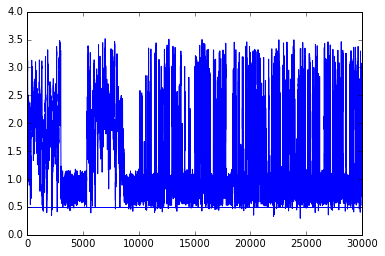

In [232]:
dis = np.array([pbcdist(frame[0],frame[1]) for frame in t.ptraj])
plt.plot(dis)
plt.axhline(y=.5)
plt.show()

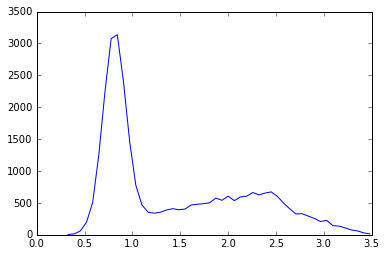

In [233]:
val,bi = np.histogram(dis,bins=50)
plt.plot((bi[:-1]+bi[1:])/2.,val)
plt.show()

In [234]:
class bond_formation_reaction(reaction):
    """
    creates a bond of given type between two particles
    """    
    def __init__(self, name, rate, bonds, ):
        self.bonds = bonds
        super(bond_formation_reaction,self).__init__(name,rate)
        
    def effect_reaction(self,encunter_complex_in):
        p0 = encunter_complex_in[0]
        p1 = encunter_complex_in[1]
        if not(any([term.name==self.bonds.name for term in p0.energyterms])):
            #print("%s: effect it"%self.name)
            self.counter += 1
            bonds = [deepcopy(self.bonds),deepcopy(self.bonds)]
            bonds[0].assign_partner(p0)
            bonds[1].assign_partner(p1)
            p0.add_energyterm(bonds[1])
            p1.add_energyterm(bonds[0])
        return [p0,p1]
        
    

class bond_breaking_reaction(reaction):
    """
    breaks abond (type??)
    """
    def __init__(self, name, rate, bonds):
        self.bonds = bonds
        super(bond_breaking_reaction,self).__init__(name,rate)
    
    def effect_reaction(self,encunter_complex_in):
        p0 = encunter_complex_in[0]
        p1 = encunter_complex_in[1]
        #look for the term with the right name
        n0 = [term.name==self.bonds.name and term.partner==p1 for term in p0.energyterms]
        n1 = [term.name==self.bonds.name and term.partner==p0 for term in p1.energyterms]

        if any(n0) and any(n1):
            m0 = list(np.where(n0)[0])
            m1 = list(np.where(n1)[0])
            #print(m0)
            #print(m1)
            #print("%s effect breaking ==== "%self.name )
            self.counter += 1
            del(p0.energyterms[m0[0]])
            del(p1.energyterms[m1[0]])
        return [p0,p1]

In [235]:
def pbcdist(p1,p2):
    box = p1.ptype.geometry.size
    pos1 = p1.pos - np.floor(p1.pos/box) * box
    pos2 = p2.pos - np.floor(p2.pos/box) * box
    delta = (pos1 - pos2)
    delta = delta - np.rint(delta/box)* box
    return np.sqrt((delta*delta).sum())

In [243]:

def setup_dim():
    membrane = geometry(dim=2,size=5)
    q1 = ptype(5e-2,"mono",membrane)
    a = particle(q1,pos=np.array([2,2]),age=0)
    b = particle(q1,pos=np.array([0,0]),age=0)
    init_pos=[a,b]
    hca = hardcore(50.,.5,a)
    hcb = hardcore(50.,.5,b)
    b.add_energyterm(hca)
    a.add_energyterm(hcb)
    cov1 = bondterm(k=10.,d=.8)

    ec1=bim_encunter_complex("grab",q1,q1,dist=1)
    rea1 = bond_formation_reaction("dimerization 1", rate=.1, bonds=cov1)
    ec1.add_reaction(rea1)
    rea2 = bond_breaking_reaction("disruption 1", rate=.01, bonds=cov1)
    ec1.add_reaction(rea2)
    t = traj(init_pos)
    return (t, [ec1])


n_replicas=5
sett = []
for i in range(n_replicas):
    t2, reacts = setup_dim()
    run1 = runner(100000, timestep = .1,stride=20)
    run1.run(t2, reactions_bim = reacts ,verbose=False)
    sett.append(t2)
    
em1 = ensemble(sett)
em1.describe()

Ensemble has 5 trajectories
Length 5001 (5000)
Length 5001 (5000)
Length 5001 (5000)
Length 5001 (5000)
Length 5001 (5000)


In [246]:
em1.trajs[0]

In [248]:
distances=[]
for tr in em1.trajs:
    dis = np.array([pbcdist(frame[0],frame[1]) for frame in tr.ptraj])
    distances.append(dis)

dis=np.concatenate(distances)

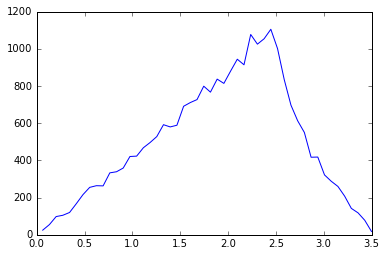

In [249]:
val,bi = np.histogram(dis,bins=50)
plt.plot((bi[:-1]+bi[1:])/2.,val)
plt.show()